In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd, optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import random

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

writer = SummaryWriter(logdir='runs/GAN_training')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img_numpy = img.numpy()
    print(img_numpy.shape)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf = 28, channels=1, bias = True):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*4, kernel_size=4, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, channels, kernel_size=4, stride=2, padding=3, bias=bias),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def discriminator_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *discriminator_block(channels, ndf, bn=False),
            *discriminator_block(ndf, ndf*2, bn=True),
            *discriminator_block(ndf*2, ndf*4, bn=True)
        )

        self.last_layer = nn.Sequential(
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=bias),
            nn.Sigmoid()
        )

    def forward_features(self, x):
        features = self.features(x)
        return features

    def forward(self, x):
        features = self.forward_features(x)
        validity = self.last_layer(features)
        return validity

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def encoder_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *encoder_block(channels, ndf, bn=False),
            *encoder_block(ndf, ndf*2, bn=True),
            *encoder_block(ndf*2, ndf*4, bn=True),
            nn.Conv2d(ndf*4, latent_dim, 4, 1, 0, bias=bias),
            nn.Tanh()
        )

    def forward(self, x):
        validity = self.features(x)
        return validity

In [6]:
n_epochs = 10
batch_size = 512
lr = 0.0002
ndf = 28
ngf = 28
latent_dim = 100
img_size = 28
channels = 1
n_critic = 5
sample_interval = 400
training_label = 0
split_rate = 0.8
lambda_gp = 10

In [7]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]

        if self.transform:
            data = self.transform(data)

        return data, labels

In [8]:
import pandas as pd

df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')
test_df = pd.read_csv('./data/test.csv')

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(df)

In [9]:
from sklearn.covariance import EllipticEnvelope

val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal

cov = EllipticEnvelope(support_fraction = 0.001, contamination = val_contamination+0.0002,random_state=777)
ee_pred = cov.fit_predict(df.drop('ID',axis=1))
ee_pred = list(map(lambda x : int(0) if x==1 else int(1), ee_pred))

df['targets'] = ee_pred

c:\Users\kimji\.conda\envs\for_pytorch\lib\site-packages\sklearn\covariance\_empirical_covariance.py:87: UserWarning: Only one sample available. You may want to reshape your data array
  "Only one sample available. You may want to reshape your data array"


In [10]:
df.drop(['V8','V22'],axis=1,inplace=True)

In [11]:
ls2 = []
col = df.columns[1:-1]

for i in df[df['targets']==0].apply(lambda x : [x[i] for i in col],axis=1):
    ls = []
    for j in i:
        ls.append(np.array(i)*j)
    ls2.append(ls)

In [12]:

_x_train = torch.FloatTensor(ls2)
x_train, x_test_normal = _x_train.split((int(len(_x_train) * split_rate)), dim=0)

_y_train = torch.FloatTensor(df[df['targets']==0]['targets'])
y_train, y_test_normal = _y_train.split((int(len(_y_train) * split_rate)), dim=0)

train_mnist = SimpleDataset(x_train, y_train,
                                transform=transforms.Compose(
                                    [transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5])])
                                )
train_dataloader = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

In [13]:
G = Generator(latent_dim = latent_dim, ngf=ngf, channels=channels, bias=True).to(device)
D = Discriminator(ndf=ndf, channels=channels, bias=True).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, weight_decay=1e-5)
optimizer_D = optim.Adam(D.parameters(), lr=lr, weight_decay=1e-5)

In [14]:
# %load_ext tensorboard
# %tensorboard --logdir runs --port=6008

In [15]:
padding_epoch = len(str(n_epochs)) #3
padding_i = len(str(len(train_dataloader))) # 2

d_losses = []
g_losses = []

criterion = nn.BCELoss()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

        fake_imgs = G(z)

        real_validity = D(real_imgs)
        fake_validity = D(fake_imgs.detach())
        
        # Adversarial loss
        d_loss_real = criterion(real_validity, torch.ones_like(real_validity).to(device))
        d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity).to(device))
        d_loss = d_loss_real + d_loss_fake

        d_loss.backward()
        
        optimizer_D.step()
        
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            
            fake_imgs = G(z)
            fake_validity = D(fake_imgs)

            g_loss = criterion(fake_validity, torch.ones_like(fake_validity).to(device))

            g_loss.backward()
            optimizer_G.step()
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            writer.add_scalars('GAN loss', {'G_loss': g_loss.item(), 'D_loss': d_loss.item()}, epoch)
            
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                f"[D loss: {d_loss.item():3f}] "
                f"[G loss: {g_loss.item():3f}]")
print('Finished Training')

[Epoch  0/10] [Batch   0/178] [D loss: 1.396476] [G loss: 0.847550]
[Epoch  0/10] [Batch   5/178] [D loss: 0.814638] [G loss: 1.374948]
[Epoch  0/10] [Batch  10/178] [D loss: 0.522458] [G loss: 1.748076]
[Epoch  0/10] [Batch  15/178] [D loss: 0.381238] [G loss: 2.117270]
[Epoch  0/10] [Batch  20/178] [D loss: 0.318181] [G loss: 2.441781]
[Epoch  0/10] [Batch  25/178] [D loss: 0.262008] [G loss: 2.830462]
[Epoch  0/10] [Batch  30/178] [D loss: 0.238787] [G loss: 3.085837]
[Epoch  0/10] [Batch  35/178] [D loss: 0.185414] [G loss: 3.411253]
[Epoch  0/10] [Batch  40/178] [D loss: 0.153989] [G loss: 3.752716]
[Epoch  0/10] [Batch  45/178] [D loss: 0.129790] [G loss: 4.242389]
[Epoch  0/10] [Batch  50/178] [D loss: 0.086564] [G loss: 4.584935]
[Epoch  0/10] [Batch  55/178] [D loss: 0.064384] [G loss: 4.986243]
[Epoch  0/10] [Batch  60/178] [D loss: 0.042562] [G loss: 5.248400]
[Epoch  0/10] [Batch  65/178] [D loss: 0.034639] [G loss: 5.480873]
[Epoch  0/10] [Batch  70/178] [D loss: 0.028447]

In [16]:
# plt.plot(g_losses, label='g_loss')
# plt.plot(d_losses, label='d_loss')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 242, 242)


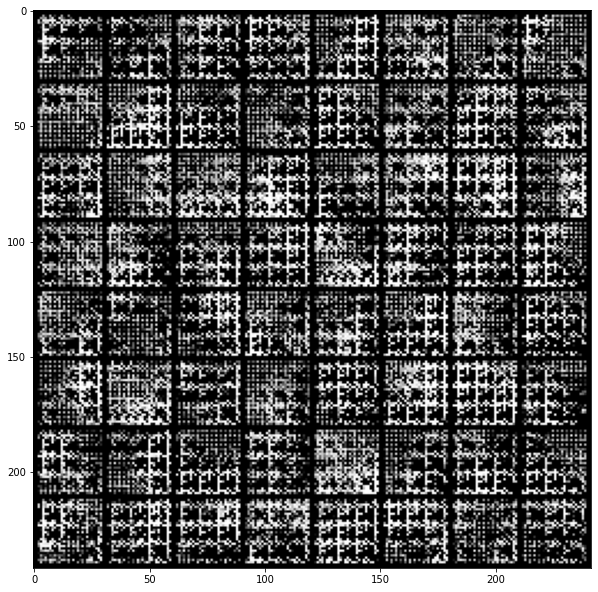

In [20]:
z = torch.randn(64, latent_dim, 1, 1).to(device)
imshow_grid(G(z))

In [18]:
fake_imgs[0].shape

torch.Size([1, 28, 28])

In [19]:
writer = SummaryWriter(logdir='runs/Encoder_training')

E = Encoder(latent_dim, ndf, channels, bias=True).to(device)

G.eval()
D.eval()

criterion = nn.MSELoss()

optimizer_E = torch.optim.Adam(E.parameters(), lr=lr, betas=(0.0, 0.999))

padding_epoch = len(str(n_epochs))
padding_i = len(str(len(train_dataloader)))
kappa = 1.0
e_losses = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        
        optimizer_E.zero_grad() 
        z = E(real_imgs)
        
        fake_imgs = G(z)

        real_features = D.forward_features(real_imgs)
        fake_features = D.forward_features(fake_imgs)
        # real_feature = real_features / real_features.max()
        # fake_features = fake_features / fake_features.max()

        # izif architecture
        loss_imgs = criterion(fake_imgs, real_imgs)
        loss_features = criterion(fake_features, real_features)
        e_loss = loss_imgs + kappa * loss_features

        e_loss.backward()
        optimizer_E.step()


        if i % n_critic == 0:
            e_losses.append(e_loss)

            writer.add_scalar('e_loss', e_loss.item(), epoch)
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                    f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                    f"[E loss: {e_loss.item():3f}]")
            
#writer.close()
print('Finished Training')

[Epoch  0/10] [Batch   0/178] [E loss: 1.940773]
[Epoch  0/10] [Batch   5/178] [E loss: 1.676309]
[Epoch  0/10] [Batch  10/178] [E loss: 1.656092]
[Epoch  0/10] [Batch  15/178] [E loss: 1.637120]
[Epoch  0/10] [Batch  20/178] [E loss: 1.614772]
[Epoch  0/10] [Batch  25/178] [E loss: 1.596959]
[Epoch  0/10] [Batch  30/178] [E loss: 1.590282]
[Epoch  0/10] [Batch  35/178] [E loss: 1.563783]
[Epoch  0/10] [Batch  40/178] [E loss: 1.553007]
[Epoch  0/10] [Batch  45/178] [E loss: 1.539671]
[Epoch  0/10] [Batch  50/178] [E loss: 1.564884]
[Epoch  0/10] [Batch  55/178] [E loss: 1.547019]
[Epoch  0/10] [Batch  60/178] [E loss: 1.532475]
[Epoch  0/10] [Batch  65/178] [E loss: 1.556830]
[Epoch  0/10] [Batch  70/178] [E loss: 1.547458]
[Epoch  0/10] [Batch  75/178] [E loss: 1.534915]
[Epoch  0/10] [Batch  80/178] [E loss: 1.553013]
[Epoch  0/10] [Batch  85/178] [E loss: 1.512909]
[Epoch  0/10] [Batch  90/178] [E loss: 1.542485]
[Epoch  0/10] [Batch  95/178] [E loss: 1.528123]
[Epoch  0/10] [Batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 242, 242)


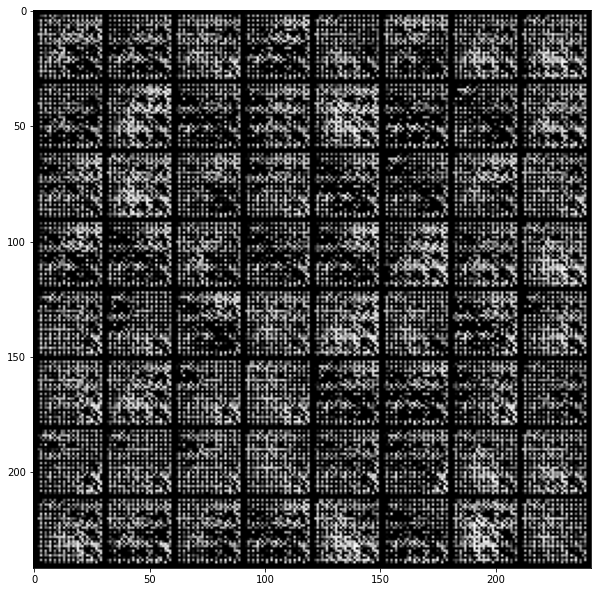

In [21]:
z = torch.randn(64, latent_dim, 1, 1).to(device) # 64, 100
fake_imgs = G(z) # 64, 1, 28, 28
fake_z = E(fake_imgs) #64, 100
reconfiguration_imgs = G(fake_z)

imshow_grid(reconfiguration_imgs)

In [39]:
# test_dataset = val_df.drop(['ID','V8','V22'],axis=1)
# # test_dataset = val_df
# val_df.rename(columns={'Class':'targets'},inplace=True)

# ls2 = []
# col = val_df.columns[:-1]

# for i in test_dataset[test_dataset['targets']!=0].apply(lambda x : [x[i] for i in col],axis=1):
#     ls = []
#     for j in i:
#         ls.append(np.array(i)*j)
#     ls2.append(ls)


# x_test = torch.FloatTensor(ls2)
# y_test = torch.FloatTensor(val_df[val_df['targets']!=0]['targets'].to_list())

# test_mnist = SimpleDataset(x_test, y_test,
#                             transform=transforms.Compose(
#                             [transforms.ToPILImage(),
#                             transforms.ToTensor(),
#                             transforms.Normalize([0.5], [0.5])])
#                             )

# test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=True)

In [64]:
# test_dataset = val_df.drop(['ID','V8','V22'],axis=1)
val_df.rename(columns={'Class':'targets'},inplace=True)
test_dataset = pd.concat([val_df[val_df['targets']==0][:50], val_df[val_df['targets']==1]])

ls2 = []
col = val_df.columns[:-1]

for i in test_dataset.apply(lambda x : [x[i] for i in col],axis=1):
    ls = []
    for j in i:
        ls.append(np.array(i)*j)
    ls2.append(ls)


x_test = torch.FloatTensor(ls2)
y_test = torch.FloatTensor(test_dataset['targets'].to_list())

test_mnist = SimpleDataset(x_test, y_test,
                            transform=transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5])])
                            )

test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=False)

In [65]:
def compare_images(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(28, 28) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(28, 28) * 255

    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    
    diff_img[diff_img <= threshold] = 0

    anomaly_img = np.zeros(shape=(28, 28, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    fig, plots = plt.subplots(1, 4)
    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label='real')
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

1.0, 0.583031415939331, 0.6371160745620728, 0.07168427109718323



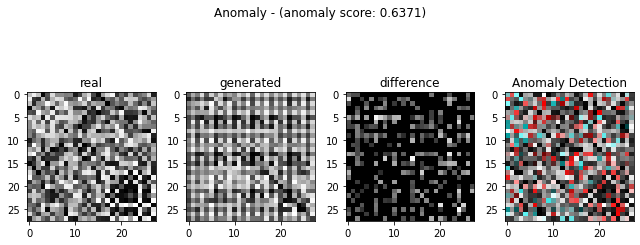

In [67]:
criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

with open("score.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

for i, (img, label) in enumerate(test_dataloader):
    real_img = img.to(device)

    real_z = E(real_img) # 진짜 이미지의 latent vector
    fake_img = G(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    real_feature = D.forward_features(real_img) # 1, 256
    fake_feature = D.forward_features(fake_img)
    real_feature = real_feature / real_feature.max()
    fake_feature = fake_feature / fake_feature.max()
    # print("real_feature max : ",real_feature.max())
    # print("real_feature min : ",real_feature.min())
    # print("fake_feature max : ",fake_feature.max())
    # print("fake_feature min : ",fake_feature.min())

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = criterion(fake_z, real_z)
    
    with open("score.csv", "a") as f:
            f.write(f"{label.item()},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")
    
    if i % 2000 == 0:
        print(f"{label.item()}, {img_distance}, "
          f"{anomaly_score}, {z_distance}\n")
        compare_images(real_img, fake_img,i, anomaly_score, reverse = False, threshold = 80)

In [68]:
df = pd.read_csv("score.csv")
df

,label,img_distance,anomaly_score,z_distance
0,1.0,0.583031,0.637116,0.071684
1,0.0,0.899413,0.949839,0.217825
2,1.0,0.606634,0.658640,0.046970
3,0.0,0.867515,0.906598,0.233118
4,0.0,0.556491,0.596901,0.097778
...,...,...,...,...
75,1.0,0.576751,0.643670,0.085685
76,0.0,0.789337,0.837342,0.172449
77,0.0,0.823078,0.906756,0.104528
78,1.0,0.566658,0.625963,0.067005


In [69]:
trainig_label = 1
labels = np.where(df["label"].values == trainig_label, 0, 1) # 라벨이 1이면 0을 반환, 아니면 1을 반환.
anomaly_score = df["anomaly_score"].values
img_distance = df["img_distance"].values
z_distance = df["z_distance"].values

In [70]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, _ = roc_curve(labels, img_distance)
precision, recall, _ = precision_recall_curve(labels, img_distance)
roc_auc = auc(fpr, tpr)
pr_auc =  auc(recall, precision)

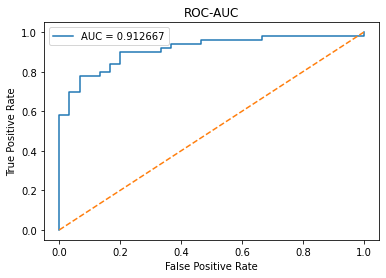

In [71]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

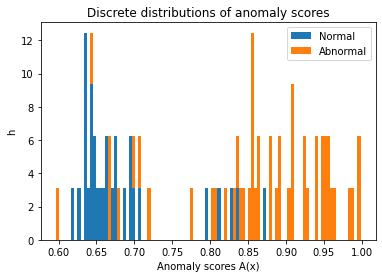

In [72]:
plt.hist([anomaly_score[labels == 0], anomaly_score[labels == 1]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.show()

In [77]:
test_df

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,0x4587f,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0.028645,1.034904
142499,0x45880,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0.810312,1.034916
142500,0x45884,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
142501,0x45885,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975


In [83]:
test_dataset = test_df
test_dataset = test_dataset.drop(['ID','V8','V22'],axis=1)

ls2 = []
col = test_dataset.columns

for i in test_dataset.apply(lambda x : [x[i] for i in col],axis=1):
    ls = []
    for j in i:
        ls.append(np.array(i)*j)
    ls2.append(ls)


x_test = torch.FloatTensor(ls2)
y_test = torch.FloatTensor([0]*test_df.shape[0])

test_mnist = SimpleDataset(x_test, y_test,
                            transform=transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5])])
                            )

test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=False)

0.0, 0.859438419342041, 0.9322938919067383, 0.09324230253696442



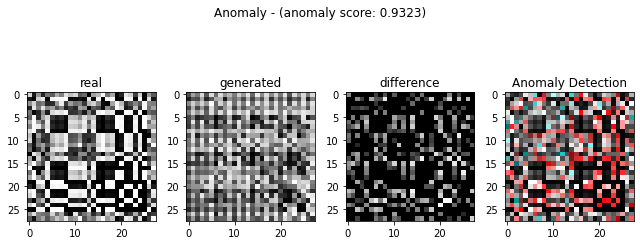

0.0, 0.7918436527252197, 0.840776264667511, 0.1451793909072876



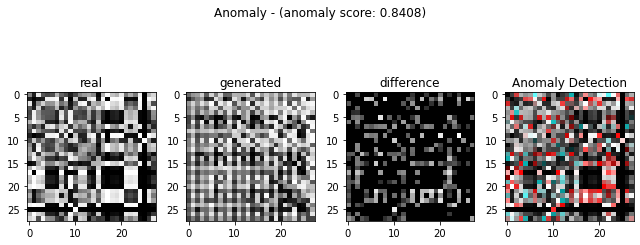

0.0, 0.7724736332893372, 0.838045597076416, 0.15652167797088623



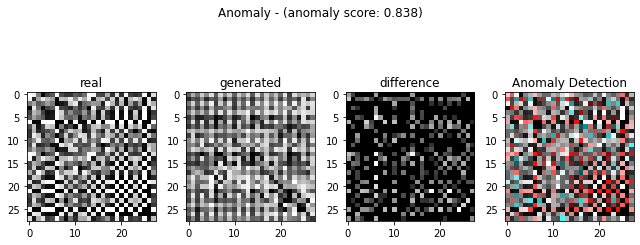

0.0, 0.7099598050117493, 0.765796422958374, 0.17901109158992767



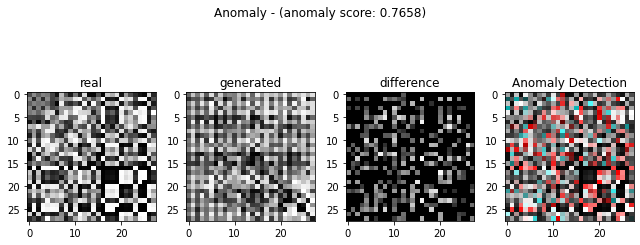

0.0, 0.7368271350860596, 0.7961499094963074, 0.13069255650043488



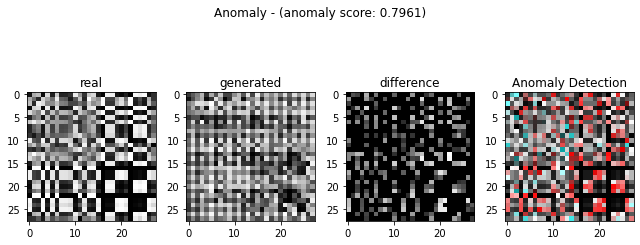

0.0, 0.8230635523796082, 0.8806755542755127, 0.12036015838384628



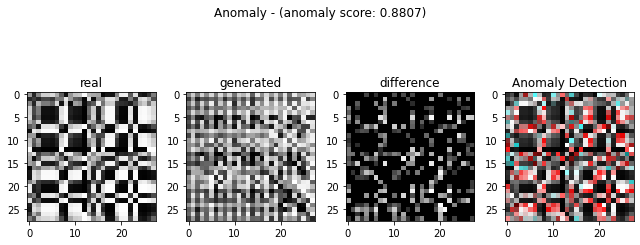

0.0, 0.7216686010360718, 0.7771948575973511, 0.07377223670482635



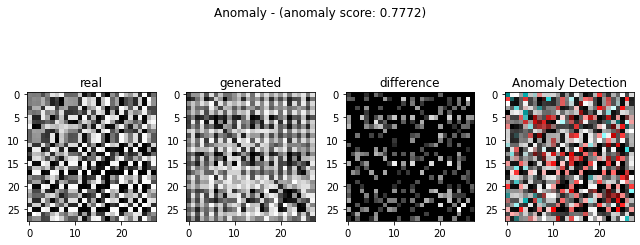

0.0, 0.8820290565490723, 0.922391414642334, 0.20611029863357544



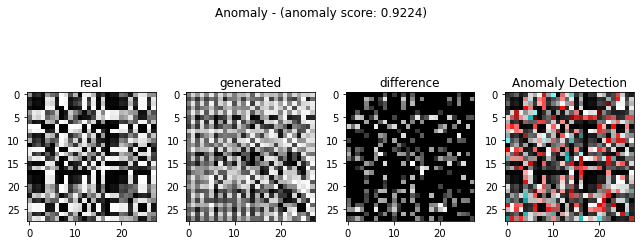

0.0, 0.7256520986557007, 0.7898604869842529, 0.08349882066249847



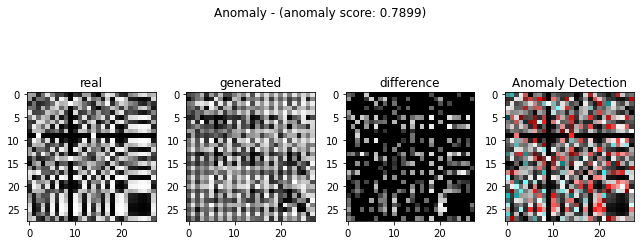

0.0, 0.7960673570632935, 0.8509096503257751, 0.19751156866550446



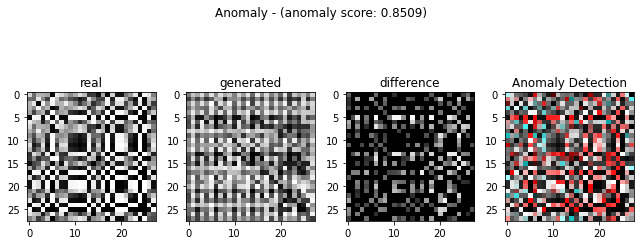

0.0, 0.8723292350769043, 0.9184711575508118, 0.1639060527086258



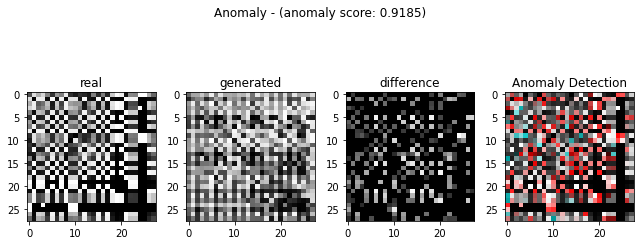

0.0, 0.7843119502067566, 0.8463919758796692, 0.20821473002433777



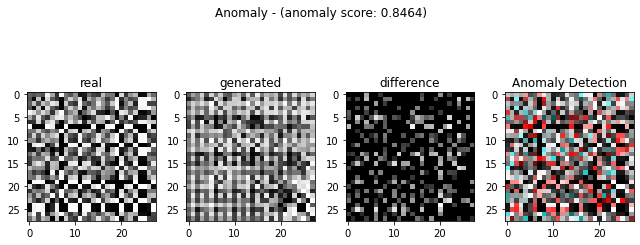

0.0, 0.9776293635368347, 1.0349626541137695, 0.21772494912147522



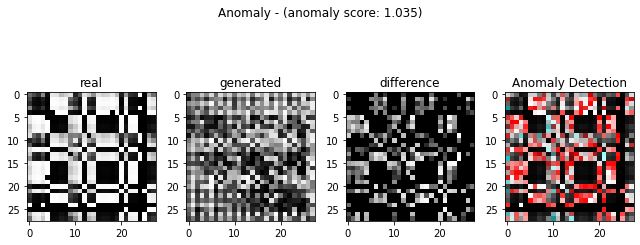

0.0, 0.8130494356155396, 0.8602864146232605, 0.18433266878128052



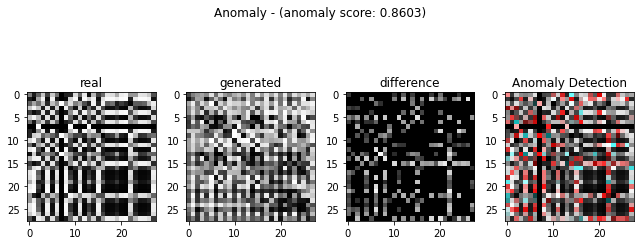

0.0, 0.665682315826416, 0.7328488230705261, 0.1067434549331665



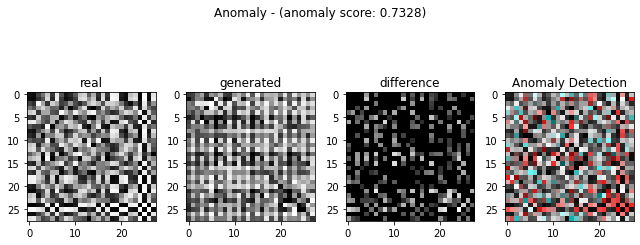

0.0, 0.7923136949539185, 0.8552683591842651, 0.1891772747039795



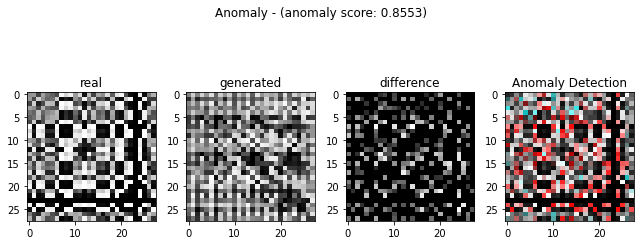

0.0, 0.7727161049842834, 0.8105397820472717, 0.11788725852966309



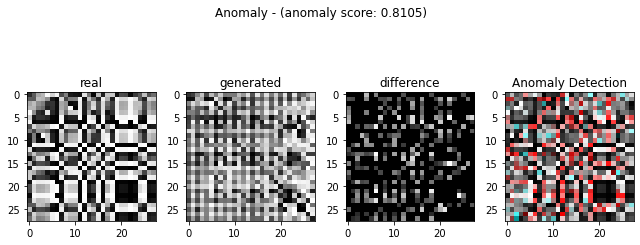

0.0, 0.7535499930381775, 0.8120137453079224, 0.1157759428024292



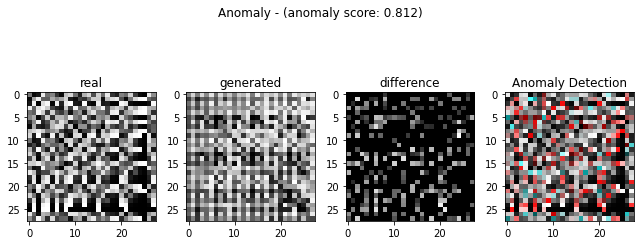

0.0, 0.7019090056419373, 0.7669543027877808, 0.10413133352994919



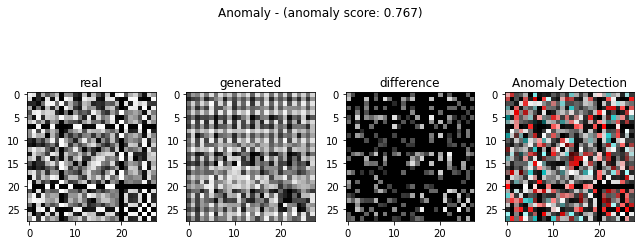

0.0, 0.6821894645690918, 0.7455264329910278, 0.12662813067436218



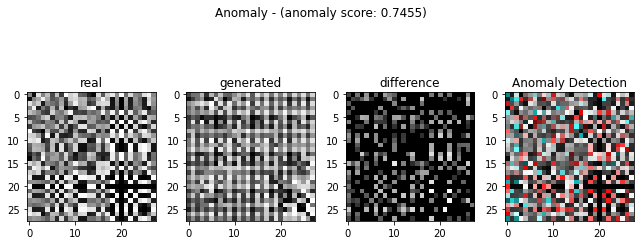

0.0, 0.8504155278205872, 0.8877458572387695, 0.20373782515525818



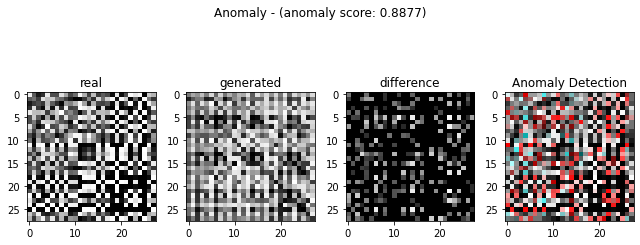

0.0, 0.8628028631210327, 0.9266244173049927, 0.17673732340335846



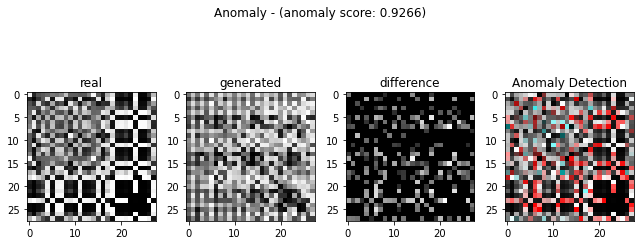

0.0, 0.7556846737861633, 0.8083373308181763, 0.13923098146915436



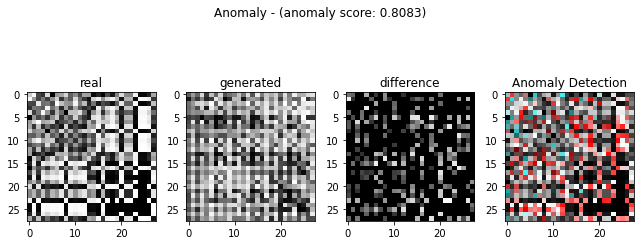

0.0, 0.8051488995552063, 0.8654673099517822, 0.1571013331413269



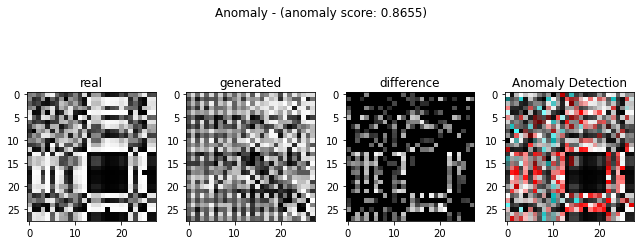

0.0, 0.7884206175804138, 0.8454545736312866, 0.13680800795555115



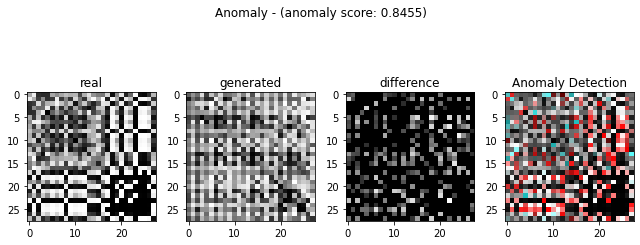

0.0, 0.7821881175041199, 0.8594200611114502, 0.15130600333213806



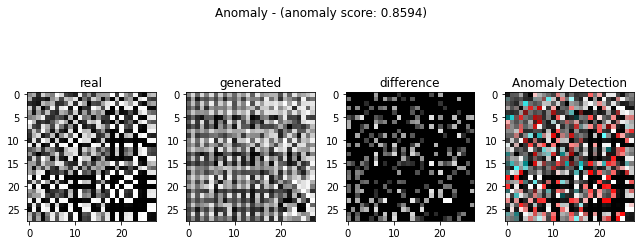

0.0, 0.8071832060813904, 0.8506615161895752, 0.1946500688791275



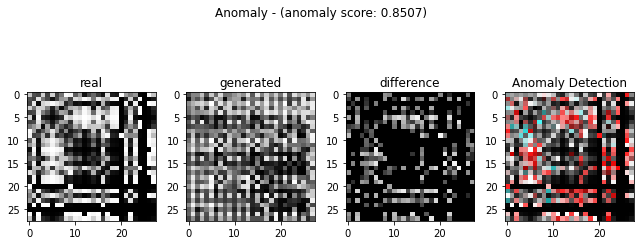

0.0, 0.9611977338790894, 1.0170280933380127, 0.33257055282592773



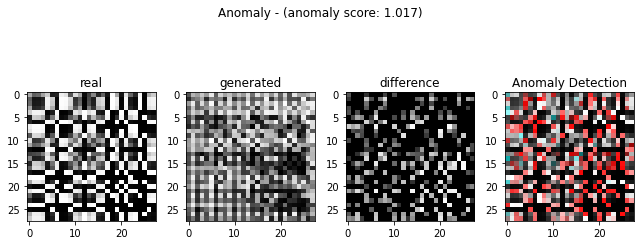

0.0, 0.8906558156013489, 0.9520425796508789, 0.2307441681623459



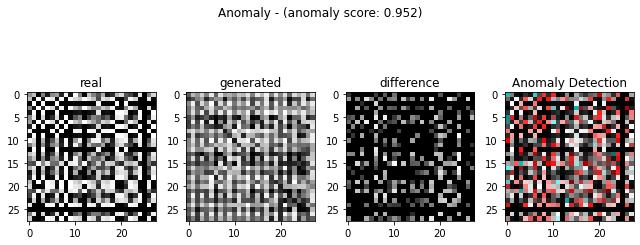

0.0, 0.6274906992912292, 0.6710072159767151, 0.1182461604475975



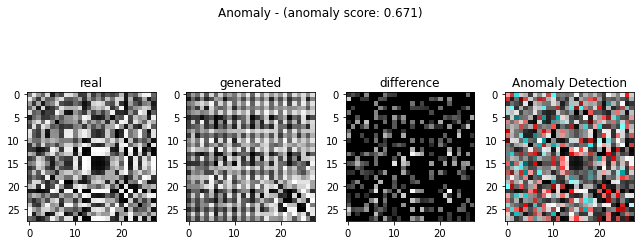

PermissionError: [Errno 13] Permission denied: 'score_test.csv'

In [85]:
criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

with open("score_test.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

for i, (img, label) in enumerate(test_dataloader):
    real_img = img.to(device)

    real_z = E(real_img) # 진짜 이미지의 latent vector
    fake_img = G(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    real_feature = D.forward_features(real_img) # 1, 256
    fake_feature = D.forward_features(fake_img)
    real_feature = real_feature / real_feature.max()
    fake_feature = fake_feature / fake_feature.max()
    # print("real_feature max : ",real_feature.max())
    # print("real_feature min : ",real_feature.min())
    # print("fake_feature max : ",fake_feature.max())
    # print("fake_feature min : ",fake_feature.min())

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = criterion(fake_z, real_z)
    
    with open("score_test.csv", "a") as f:
            f.write(f"{label.item()},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")
    
    if i % 2000 == 0:
        print(f"{label.item()}, {img_distance}, "
          f"{anomaly_score}, {z_distance}\n")
        compare_images(real_img, fake_img,i, anomaly_score, reverse = False, threshold = 80)